# Hidden markov models 
Para complementar el meta labeling, se aplican cadenas de markov para obtener las distintas regiones de volatilidad. 

In [4]:
import sys
import os
import pandas as pd

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import quantstats as qs

from hmmlearn.hmm import GaussianHMM


In [8]:
# DATOS ORIGINALES

#SPY
spy_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\00_api_data\SPY_all.parquet')
spy_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\SPY_dollar_imbalance.parquet')
spy_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\SPY_volume_imbalance.parquet')


#BTC
btc_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\00_api_data\BTC_all.parquet')
btc_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\BTC_dollar_imbalance.parquet')
btc_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\01_imbalance_bars\BTC_volume_imbalance.parquet')


btc_data['date'] = pd.to_datetime(btc_data['date'])
spy_data['date'] = pd.to_datetime(spy_data['date'])

In [12]:
# CALCULO RANGO
spy_data["range"] = (spy_data["high"] / spy_data["low"])-1
spy_dollar_imb["range"] = (spy_dollar_imb["high"] / spy_dollar_imb["low"])-1
spy_volume_imb["range"] = (spy_volume_imb["high"] / spy_volume_imb["low"])-1
btc_data["range"] = (btc_data["high"] / btc_data["low"])-1
btc_dollar_imb["range"] = (btc_dollar_imb["high"] / btc_dollar_imb["low"])-1
btc_volume_imb["range"] = (btc_volume_imb["high"] / btc_volume_imb["low"])-1

# SPY

In [20]:
percent_80 = int(len(spy_data)*0.8)
X_train = spy_data[["log_returns", "range"]].iloc[:percent_80]
X_test = spy_data[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_data) }")

X_train From:	 1  to  529882 | Length:  529882
X_test From:	 529883  to  662353 | Length:  132471
Total samples: 662353. Están todos?:True


In [41]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 6886316.879848255


In [42]:
spy_data['HMM'] = hmm_model.predict(spy_data[["log_returns", "range"]])

In [43]:
spy_data['HMM'].value_counts()

HMM
2    362729
3    186226
0    104643
1      8755
Name: count, dtype: int64

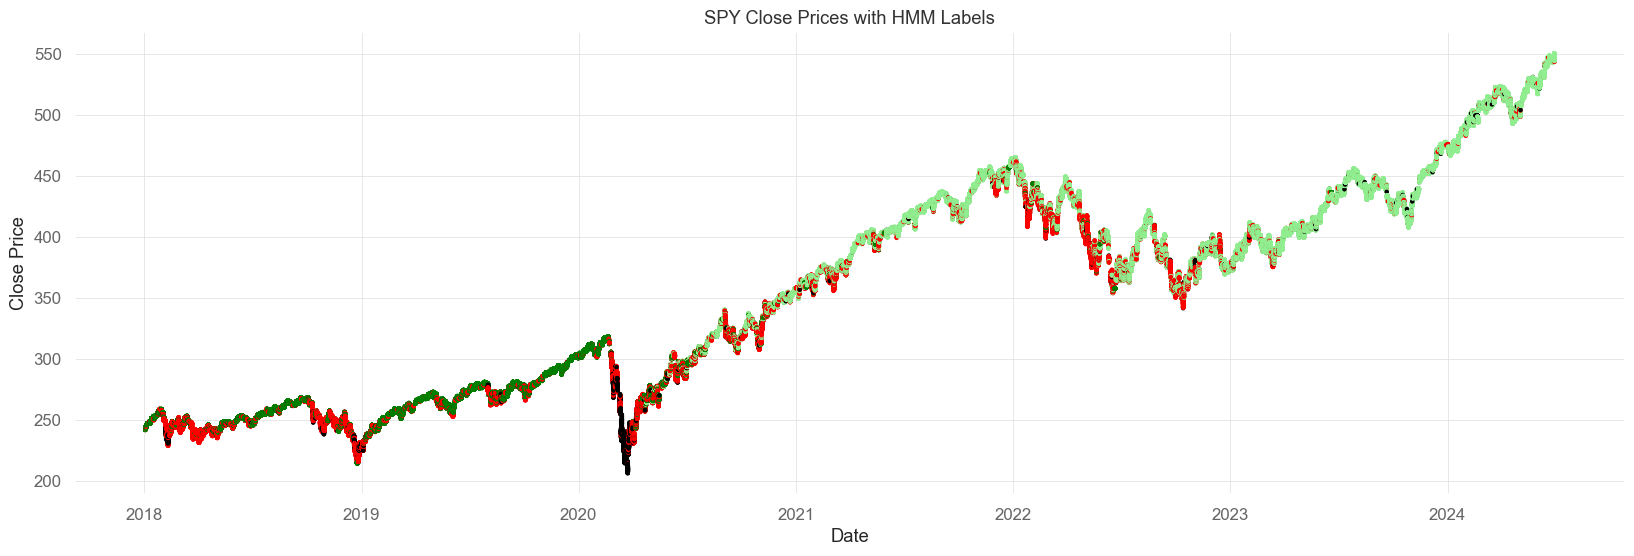

In [46]:
# Convertir 'date' a datetime si es necesario
spy_data['date'] = pd.to_datetime(spy_data['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_data['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_data['date'], spy_data['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# SPY VOLUME

In [49]:
percent_80 = int(len(spy_volume_imb)*0.8)
X_train = spy_volume_imb[["log_returns", "range"]].iloc[:percent_80]
X_test = spy_volume_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_volume_imb) }")

X_train From:	 1  to  44344 | Length:  44344
X_test From:	 44345  to  55430 | Length:  11086
Total samples: 55430. Están todos?: True


In [50]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model is not converging.  Current: 458320.91189537017 is not greater than 458320.93772677804. Delta is -0.025831407867372036


Model Score: 458320.84694336355


In [51]:
spy_volume_imb['HMM'] = hmm_model.predict(spy_volume_imb[["log_returns", "range"]])

In [52]:
spy_volume_imb['HMM'].value_counts()

HMM
2    32619
3    17917
0     3846
1     1048
Name: count, dtype: int64

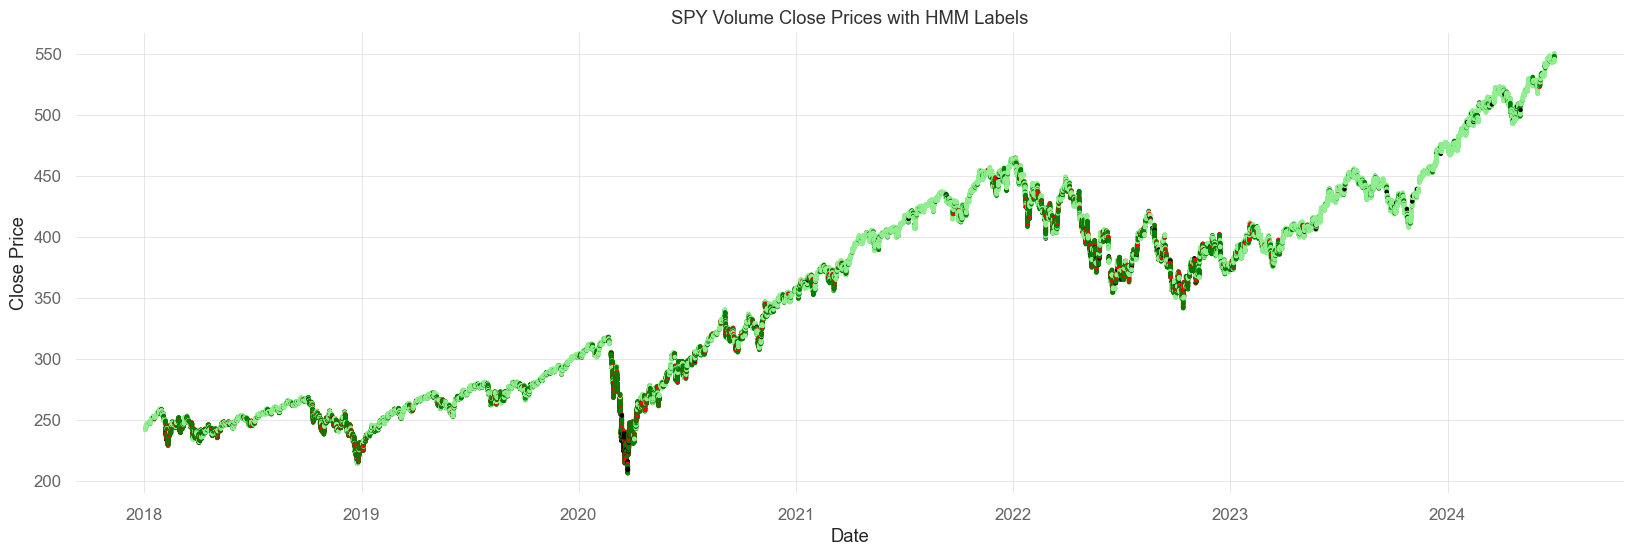

In [53]:
# Convertir 'date' a datetime si es necesario
spy_volume_imb['date'] = pd.to_datetime(spy_volume_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_volume_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_volume_imb['date'], spy_volume_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Volume Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# SPY DOLLAR

In [55]:
percent_80 = int(len(spy_dollar_imb)*0.8)
X_train = spy_dollar_imb[["log_returns", "range"]].iloc[:percent_80]
X_test = spy_dollar_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(spy_dollar_imb) }")

X_train From:	 1  to  68182 | Length:  68182
X_test From:	 68183  to  85228 | Length:  17046
Total samples: 85228. Están todos?: True


In [56]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 731753.6363794751


In [57]:
spy_dollar_imb['HMM'] = hmm_model.predict(spy_dollar_imb[["log_returns", "range"]])

In [58]:
spy_dollar_imb['HMM'].value_counts()

HMM
2    52644
3    30066
0     1627
1      891
Name: count, dtype: int64

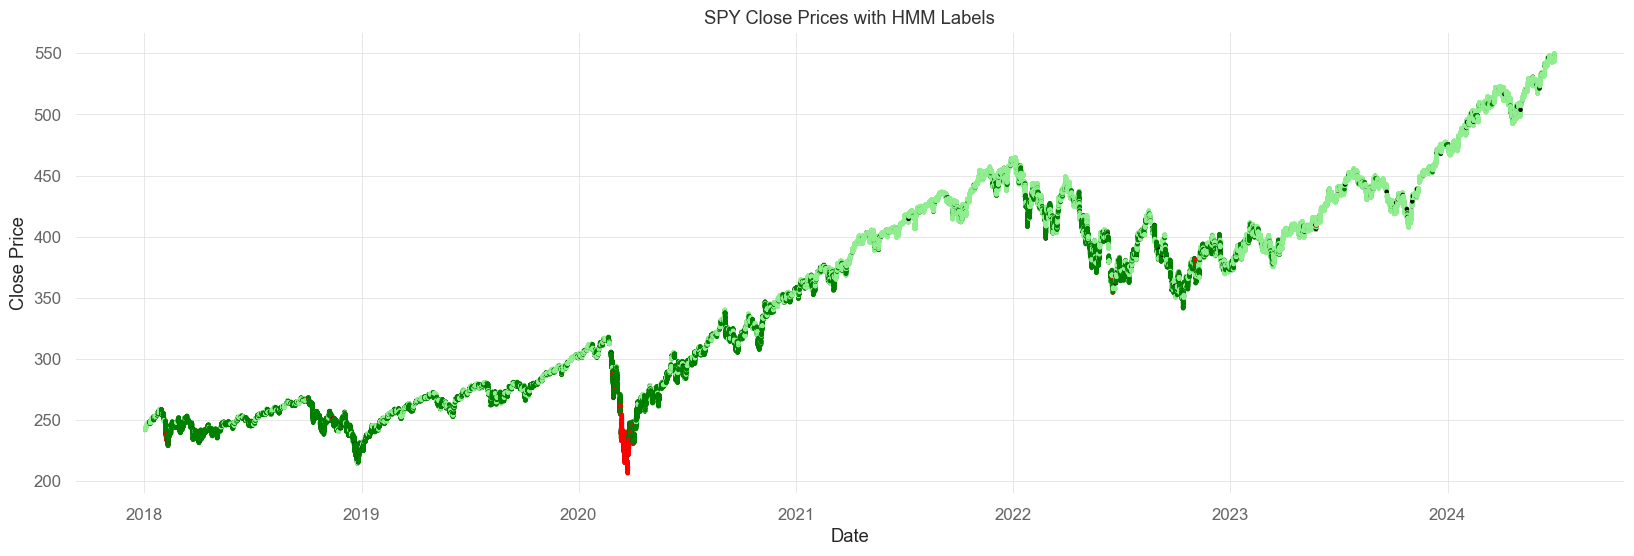

In [59]:
# Convertir 'date' a datetime si es necesario
spy_dollar_imb['date'] = pd.to_datetime(spy_dollar_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = spy_dollar_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(spy_dollar_imb['date'], spy_dollar_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC

In [62]:
percent_80 = int(len(spy_data)*0.8)
X_train = btc_data[["log_returns", "range"]].iloc[:percent_80]
X_test = btc_data[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_data) }")

X_train From:	 1  to  529882 | Length:  529882
X_test From:	 529883  to  3417119 | Length:  2887237
Total samples: 3417119. Están todos?: True


In [63]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model is not converging.  Current: 4135120.533094091 is not greater than 4135125.107149534. Delta is -4.5740554430522025


Model Score: 4135112.9467225913


In [64]:
btc_data['HMM'] = hmm_model.predict(btc_data[["log_returns", "range"]])

In [65]:
btc_data['HMM'].value_counts()

HMM
0    2678761
3     284047
2     228243
1     226068
Name: count, dtype: int64

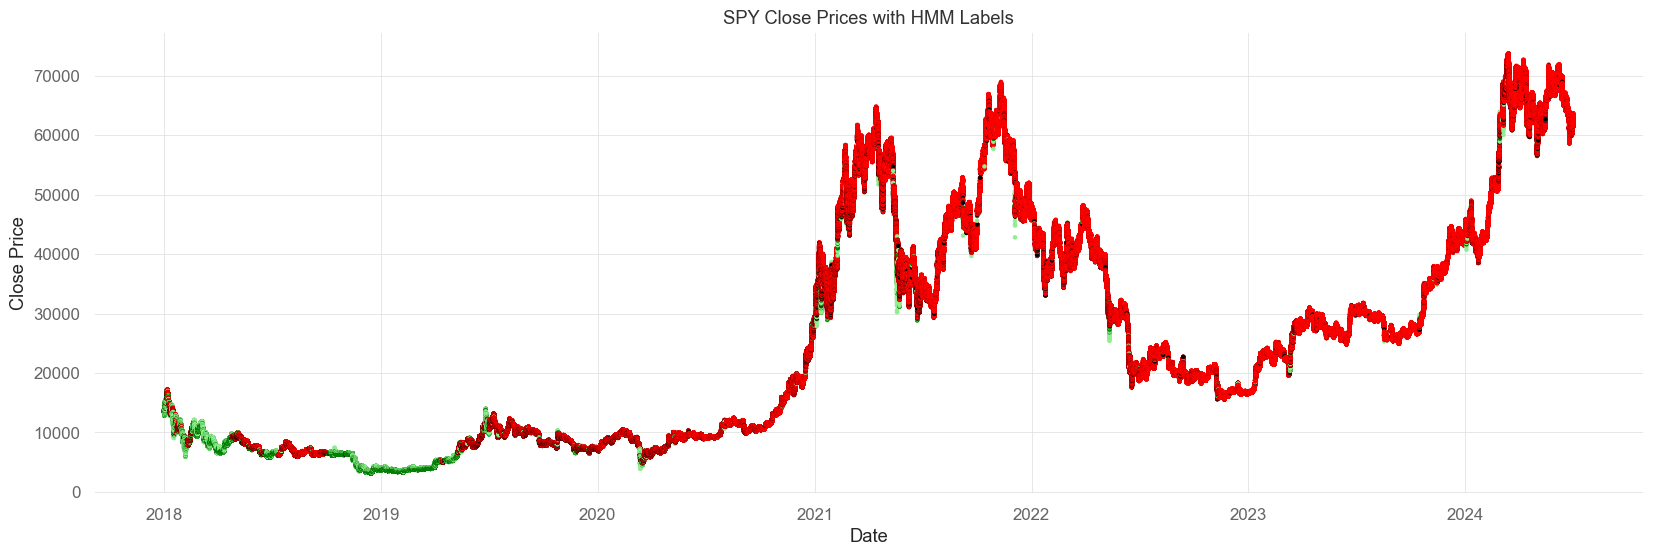

In [66]:
# Convertir 'date' a datetime si es necesario
btc_data['date'] = pd.to_datetime(btc_data['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_data['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_data['date'], btc_data['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC VOLUME

In [67]:
percent_80 = int(len(btc_volume_imb)*0.8)
X_train = btc_volume_imb[["log_returns", "range"]].iloc[:percent_80]
X_test = btc_volume_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_volume_imb) }")

X_train From:	 1  to  88617 | Length:  88617
X_test From:	 88618  to  110772 | Length:  22155
Total samples: 110772. Están todos?: True


In [68]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 709485.3333438712


In [69]:
btc_volume_imb['HMM'] = hmm_model.predict(btc_volume_imb[["log_returns", "range"]])

In [70]:
btc_volume_imb['HMM'].value_counts()

HMM
0    46155
2    42066
3    15749
1     6802
Name: count, dtype: int64

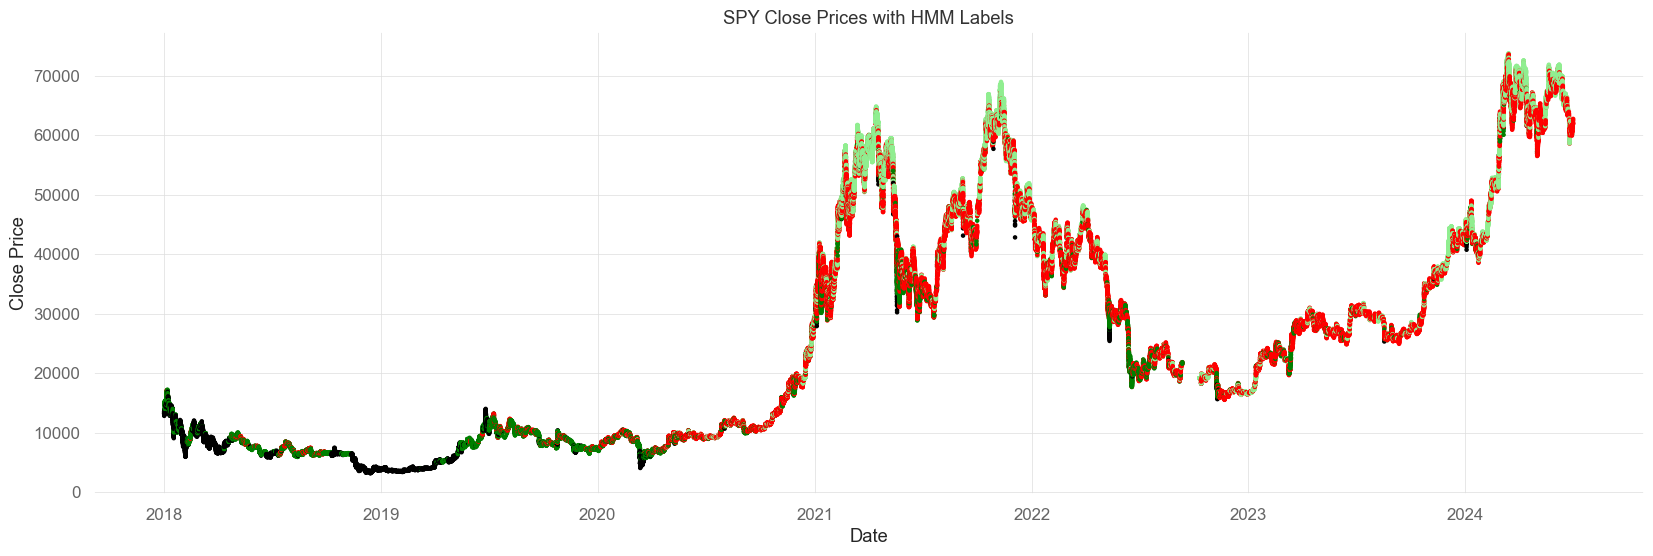

In [71]:
# Convertir 'date' a datetime si es necesario
btc_volume_imb['date'] = pd.to_datetime(btc_volume_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_volume_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_volume_imb['date'], btc_volume_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()

# BTC DOLLAR

In [72]:
percent_80 = int(len(btc_dollar_imb)*0.8)
X_train = btc_dollar_imb[["log_returns", "range"]].iloc[:percent_80]
X_test = btc_dollar_imb[["log_returns", "range"]].iloc[percent_80:]

print("X_train From:\t", X_train.index[0] , ' to ', X_train.index[-1] ,"| Length: ", len(X_train))
print("X_test From:\t", X_test.index[0] , ' to ', X_test.index[-1] ,"| Length: ", len(X_test))
print(f"Total samples: {len(X_train)+ len(X_test)}. Están todos?: {len(X_train)+ len(X_test) == len(btc_dollar_imb) }")

X_train From:	 1  to  803004 | Length:  803004
X_test From:	 803005  to  1003756 | Length:  200752
Total samples: 1003756. Están todos?: True


In [73]:
# Train Model
hmm_model = GaussianHMM(n_components=4, covariance_type = 'full',n_iter = 1000).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 8278740.242764079


In [74]:
btc_dollar_imb['HMM'] = hmm_model.predict(btc_dollar_imb[["log_returns", "range"]])

In [75]:
btc_dollar_imb['HMM'].value_counts()

HMM
0    627957
1    159982
2    146039
3     69778
Name: count, dtype: int64

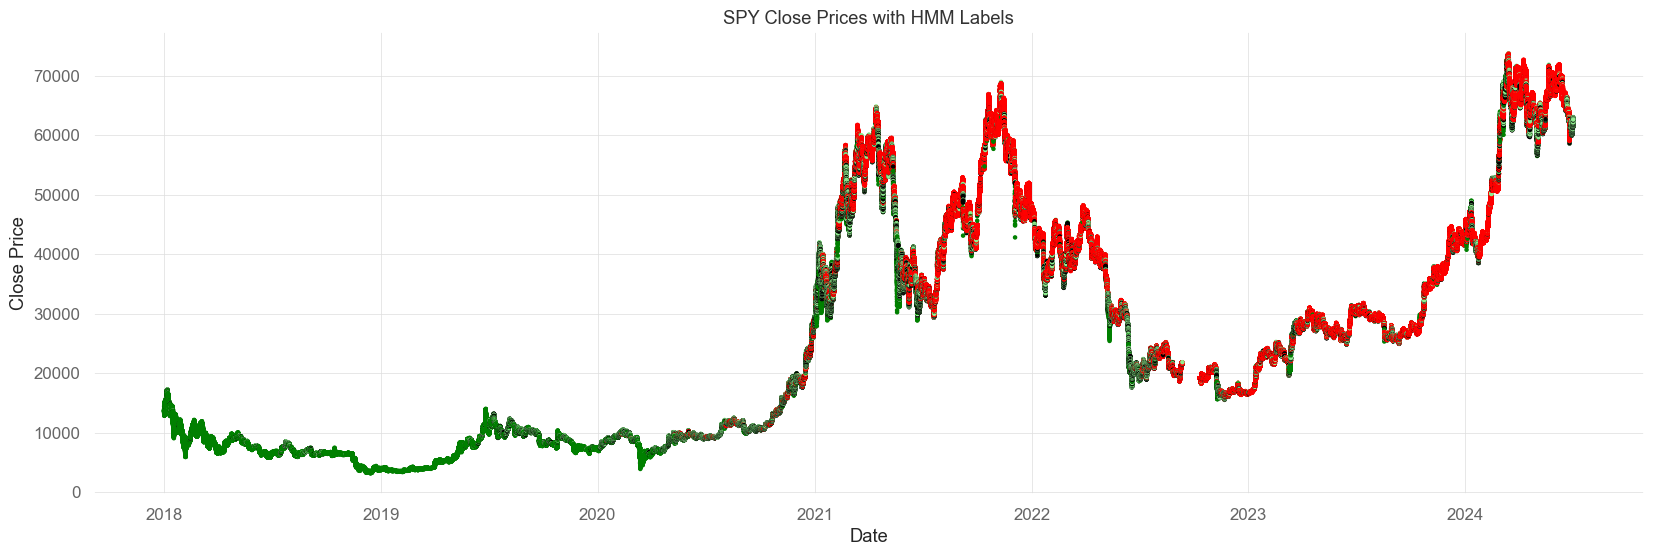

In [76]:
# Convertir 'date' a datetime si es necesario
btc_dollar_imb['date'] = pd.to_datetime(btc_dollar_imb['date'])

# Mapa de colores según los valores de HMM
label_color_map = {
    0: 'red', 
    1: 'black', 
    2: 'lightgreen', 
    3: 'green'
}

# Obtener los colores para cada punto en función de la columna HMM
colors = btc_dollar_imb['HMM'].map(label_color_map)

# Crear la gráfica
plt.figure(figsize=(20, 6))
plt.scatter(btc_dollar_imb['date'], btc_dollar_imb['close'], c=colors, s=5)

# Añadir etiquetas y título
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Close Prices with HMM Labels')
plt.grid(True)

# Mostrar la gráfica
plt.show()